Estimate the “instantaneous” median frequency (MF) and mean absolute
value (MAV) trends for both static tasks. Consider a window size of 250 ms (500 data
points) with a 125 ms overlap (250 data points) to calculate both MF and MAV. List the
MF and MAV values in a Microsoft Excel Shee

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
from scipy.ndimage import uniform_filter1d

In [24]:
def process_emg(raw):
    # Filter, rectify, and smooth EMG signal
    fs = 2000
    win = 500  # smoothing window in samples

    # Demean
    demeaned = raw - np.mean(raw, axis=0)

    # Bandpass filter (10–500 Hz)
    b, a = butter(4, [10/(fs/2), 500/(fs/2)], btype='band')
    emg_filt = filtfilt(b, a, demeaned, axis=0)

    # Notch filter at 60 Hz
    wo = 60 / (fs / 2)
    bw = wo / 35
    bn, an = iirnotch(wo, bw)
    emg_filt = filtfilt(bn, an, emg_filt, axis=0)

    # Rectify
    rectified = np.abs(emg_filt)

    # Smooth (moving average)
    processed = np.zeros_like(rectified)
    for i in range(rectified.shape[1]):
        processed[:, i] = uniform_filter1d(rectified[:, i], size=win)

    return processed


In [25]:
def calc_medf(raw):
    # Calculate median frequency for each channel using Welch PSD.
    fs = 2000
    nperseg = 500
    medf = []

    for i in range(raw.shape[1]):
        freqs, psd = welch(raw[:, i], fs=fs, nperseg=nperseg)
        cumsum = np.cumsum(psd)
        med_idx = np.where(cumsum >= cumsum[-1]/2)[0][0]
        medf.append(freqs[med_idx])

    # Repeat median freq over all time points for plotting convenience
    medf = np.tile(medf, (raw.shape[0], 1))
    return medf


In [26]:
def plot_emgs(processed_signal, med_freq):
    # Plot MAV (processed) and Median Frequency for each muscle
    muscles = ["Biceps", "Triceps", "Deltoid"]
    fs = 2000
    t = np.arange(len(processed_signal)) / fs

    fig, axs = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle("Processed EMG and Median Frequency per Muscle", fontsize=16, fontweight="bold")

    for i, m in enumerate(muscles):
        # MAV (time-domain)
        axs[i, 0].plot(t, processed_signal[:, i], 'b', linewidth=1.2)
        axs[i, 0].set_title(f"{m} MAV")
        axs[i, 0].set_ylabel("MAV")
        axs[i, 0].grid(True)

        # Median Frequency (frequency-domain)
        axs[i, 1].plot(med_freq[:, i], 'r', linewidth=1.2)
        axs[i, 1].set_title(f"{m} Median Frequency")
        axs[i, 1].set_ylabel("Median Freq (Hz)")
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

In [27]:
def remove_emg_outliers(emg):
    # Remove EMG outliers (±3σ rule)
    cleaned = emg.copy()
    for i in range(emg.shape[1]):
        mu = np.nanmean(emg[:, i])
        sigma = np.nanstd(emg[:, i])
        upper, lower = mu + 3*sigma, mu - 3*sigma
        outliers = (emg[:, i] > upper) | (emg[:, i] < lower)
        cleaned[outliers, i] = mu
    return cleaned

In [28]:
def corr_biceps_triceps(mav_signal, fs):
    # Compute correlation and intersection between biceps and triceps MAV
    if mav_signal.shape[1] < 3:
        raise ValueError("Input must have at least 3 columns: [biceps, deltoid, triceps]")

    biceps = mav_signal[:, 0]
    triceps = mav_signal[:, 2]
    t = np.arange(len(biceps)) / fs

    # Pearson correlation
    r = np.corrcoef(biceps, triceps)[0, 1]

    # Find intersection points
    diff = biceps - triceps
    sign_change = diff[:-1] * diff[1:] < 0
    idx_cross = np.where(sign_change)[0]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(t, biceps, 'b', label="Biceps MAV", linewidth=1.2)
    plt.plot(t, triceps, 'r', label="Triceps MAV", linewidth=1.2)
    plt.scatter(t[idx_cross], biceps[idx_cross], c='k', s=30, label="Intersections")
    plt.xlabel("Time (s)")
    plt.ylabel("MAV")
    plt.title("Biceps vs Triceps MAV")
    plt.legend()
    plt.grid(True)
    plt.show()

    return r



Dynamic


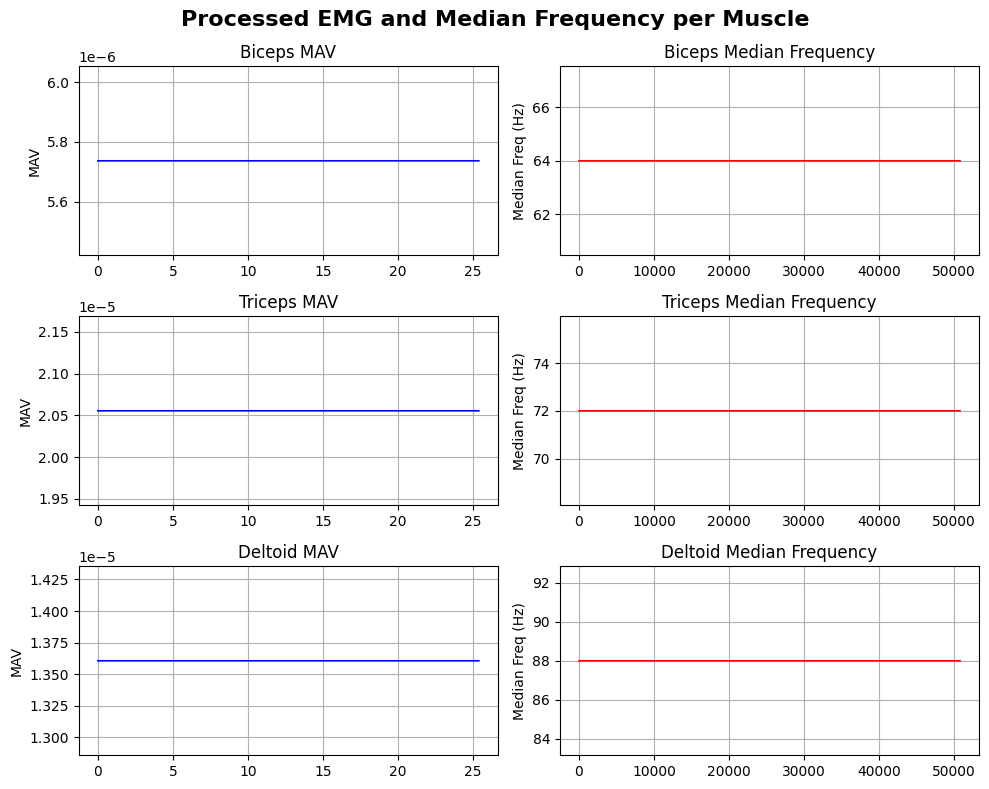

Dynamic exoskeleton


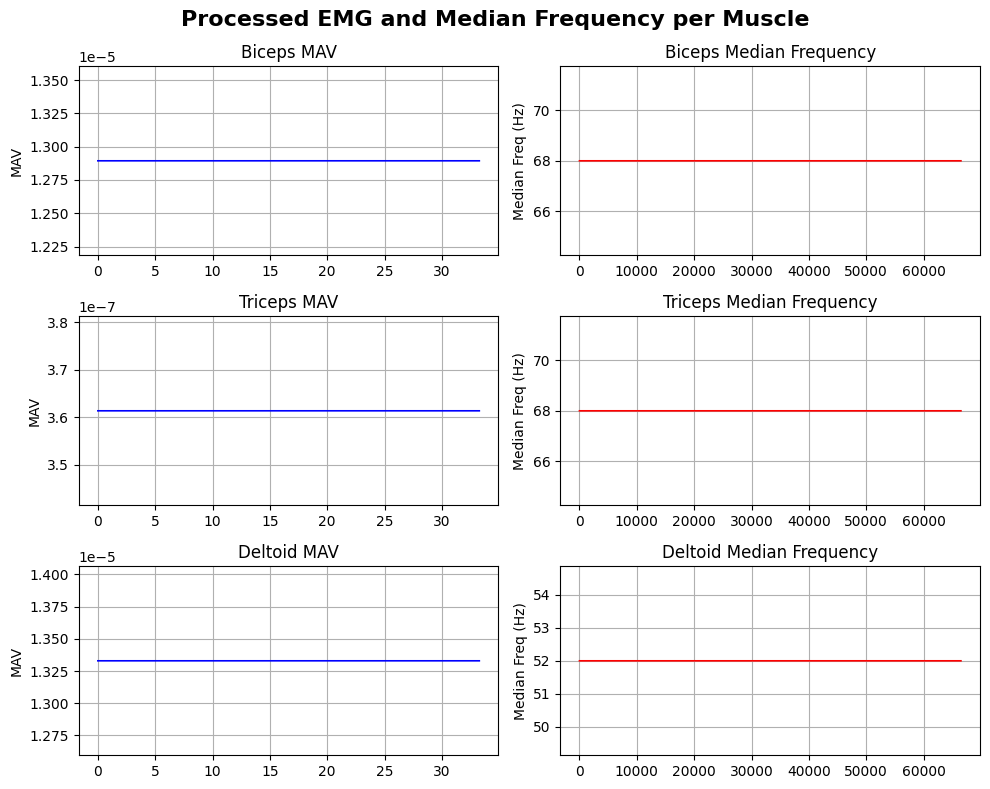

Sustained


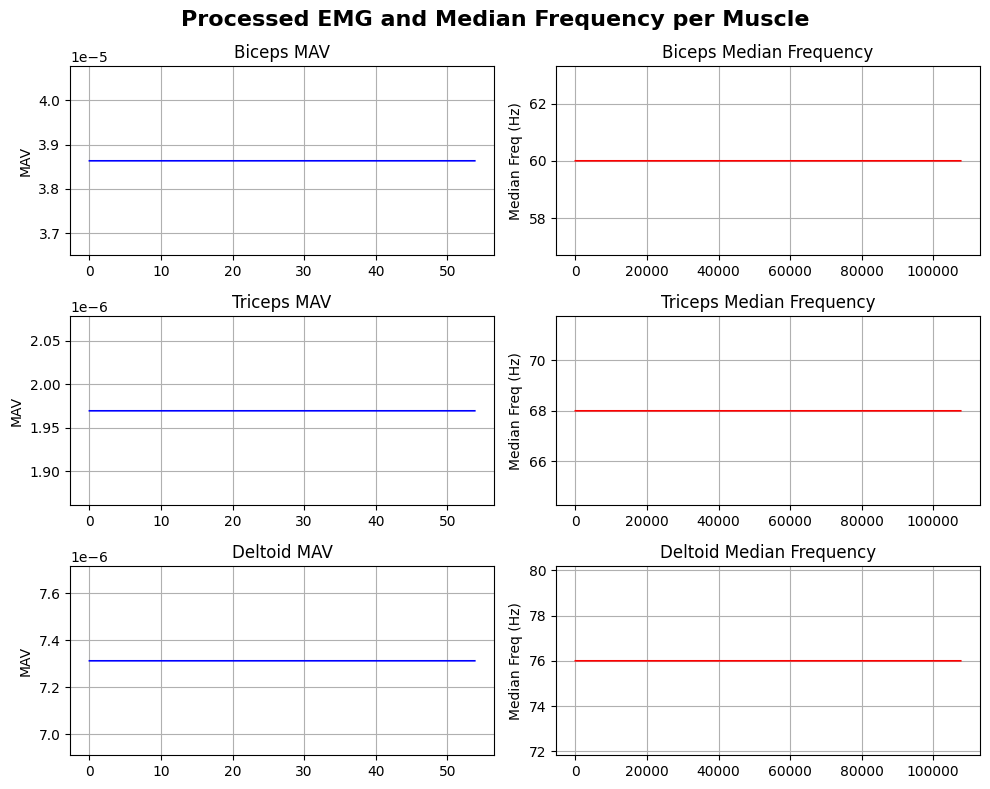

Sustained exosekleton


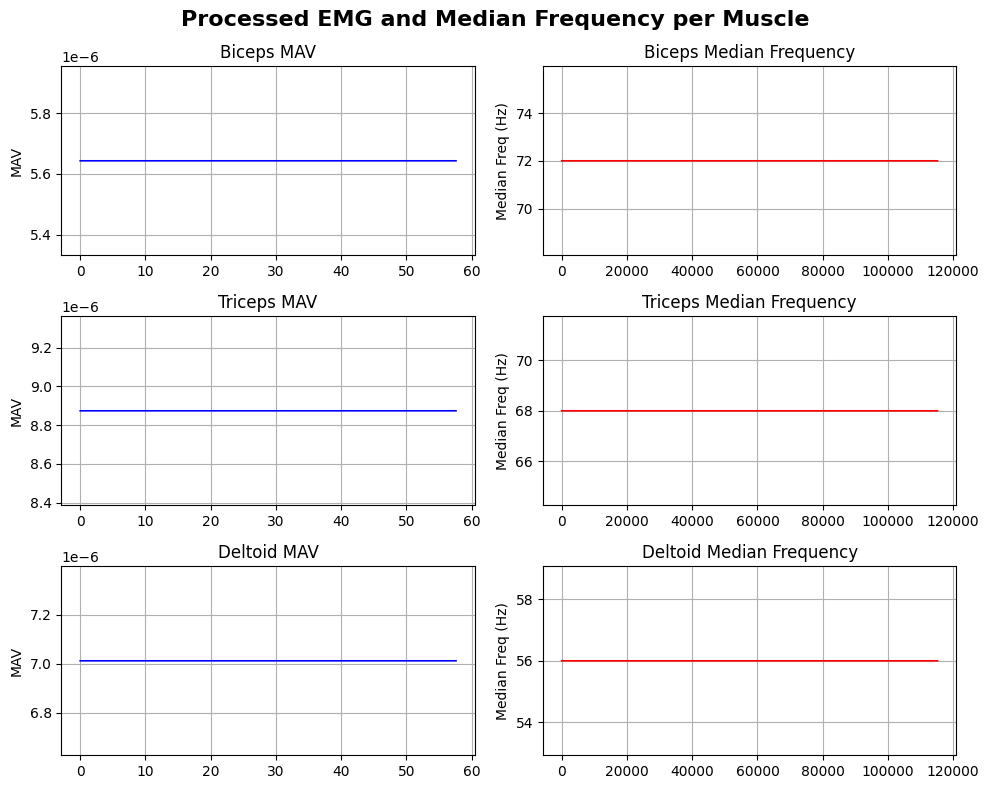

(array([[5.73714309e-06, 2.05537651e-05, 1.36057546e-05],
       [5.73714309e-06, 2.05537651e-05, 1.36057546e-05],
       [5.73714309e-06, 2.05537651e-05, 1.36057546e-05],
       ...,
       [5.73714309e-06, 2.05537651e-05, 1.36057546e-05],
       [5.73714309e-06, 2.05537651e-05, 1.36057546e-05],
       [5.73714309e-06, 2.05537651e-05, 1.36057546e-05]], shape=(50780, 3)), array([[1.28940422e-05, 3.61322772e-07, 1.33294764e-05],
       [1.28940422e-05, 3.61322772e-07, 1.33294764e-05],
       [1.28940422e-05, 3.61322772e-07, 1.33294764e-05],
       ...,
       [1.28940422e-05, 3.61322772e-07, 1.33294764e-05],
       [1.28940422e-05, 3.61322772e-07, 1.33294764e-05],
       [1.28940422e-05, 3.61322772e-07, 1.33294764e-05]], shape=(66520, 3)), array([[3.86335818e-05, 1.96946120e-06, 7.31228551e-06],
       [3.86335818e-05, 1.96946120e-06, 7.31228551e-06],
       [3.86335818e-05, 1.96946120e-06, 7.31228551e-06],
       ...,
       [3.86335818e-05, 1.96946120e-06, 7.31228551e-06],
       [3.8

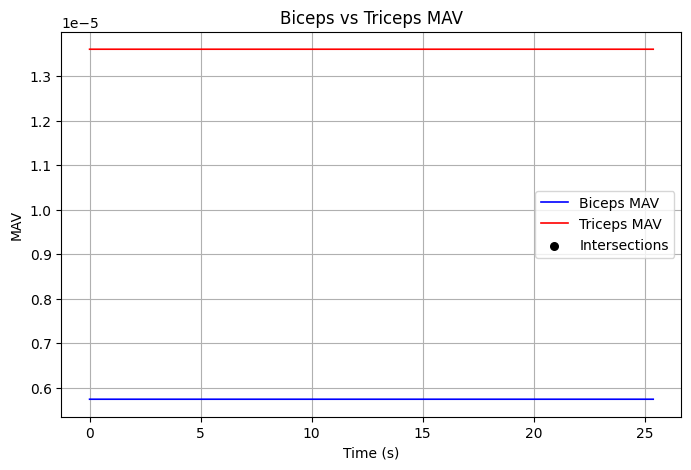

Correlation (Biceps vs Triceps): -1.000


In [29]:

# Load data
dyn = pd.read_csv("Sub02_dynamic.csv").values
dynExo = pd.read_csv("Sub02_dynamic_exo.csv").values
sus = pd.read_csv("Sub02_sustained.csv").values
susExo = pd.read_csv("Sub02_sustained_exo.csv").values

dyn 

# Process EMG signals (columns 3:5 → Python uses 0-index)
dyn_proc = process_emg(dyn[:, 2:5])
dyn_mf = calc_medf(dyn[:, 2:5])

dynExo_proc = process_emg(dynExo[:, 2:5])
dynExo_mf = calc_medf(dynExo[:, 2:5])

sus_proc = process_emg(sus[:, 2:5])
sus_mf = calc_medf(sus[:, 2:5])

susExo_proc = process_emg(susExo[:, 2:5])
susExo_mf = calc_medf(susExo[:, 2:5])

# Plot results 
print("Dynamic")
plot_emgs(dyn_proc, dyn_mf)
print("Dynamic exoskeleton")
plot_emgs(dynExo_proc, dynExo_mf)
print("Sustained")
plot_emgs(sus_proc, sus_mf)
print("Sustained exosekleton")
plot_emgs(susExo_proc, susExo_mf)

# Print values 
print((dyn_proc, dynExo_proc, sus_proc, susExo_proc))

# Correlation between biceps and triceps
r = corr_biceps_triceps(dyn_proc, 2000)
print(f"Correlation (Biceps vs Triceps): {r:.3f}")